In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import matplotlib.image as mpimg

In [77]:
def read_txt(filename):
    df = pd.read_csv(filename, sep="\t", header=0)
    return df

df = read_txt('IE440Final22ETSP.txt')
## combine x and y into one column   
combined = []
for index, row in df.iterrows():
    combined.append(np.array([row['x'], row['y']]))
df['combined'] = combined

In [78]:
def shuffle(my_list):
    shuffled_list = []
    while len(my_list) > 0:
        # Choose a random element from the list
        index = random.randint(0, len(my_list) - 1)
        element = my_list.pop(index)
        shuffled_list.append(element)
    return shuffled_list 

def Euclidean_Distance(x, y):
    return np.sqrt(np.sum((x - y)**2))

def Gaussian_Kernel(weight_bmu, weight, sigma):
    dist = Euclidean_Distance(weight_bmu, weight) # find the euclidean distance between the BMU and other neurons
    return np.exp(-dist**2/(sigma**2))

def Elastic_Band(idx_bmu, i, M, sigma):
    idx_dist = min([abs(i-idx_bmu), M - abs(i-idx_bmu)]) # find the ordering distance between the BMU and other neurons
    return np.exp(-idx_dist**2/(sigma**2))

def TSP(df):
    # Nearest Neighbor Algorithm
    # Initialize the distance matrix
    n = len(df)
    distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            distance_matrix[i, j] = Euclidean_Distance(df['combined'][i], df['combined'][j])
    # Initialize the route, distance, visited cities, unvisited cities, and current city
    route = [0]
    distance = 0
    visited = [0]
    unvisited = [i for i in range(1, n)]
    current_city = 0
    # Start the loop
    while len(unvisited) > 0:
        # Find the nearest unvisited city
        nearest_city = unvisited[0]
        for i in unvisited:
            if distance_matrix[current_city, i] < distance_matrix[current_city, nearest_city]:
                nearest_city = i
        # Update the route
        route.append(nearest_city)
        distance += distance_matrix[current_city, nearest_city]
        visited.append(nearest_city)
        unvisited.remove(nearest_city)
        current_city = nearest_city
    # Update the distance
    distance += distance_matrix[current_city, 0]
    return route, distance



def SOM_TSP(df, beta, learning_rate, sigma, M, neighborhood_function, break_point = 1e-4, max_iter = 1e+5):
    t = 0 # Initialize the counter
    n = len(df) # Number of cities
    # Initialize the weights
    weights = np.zeros((M, 2))
    weights_prev = weights.copy()  # record previous weights to check difference
    # Start the loop
    while t < max_iter:
        ## Shuffle the cities
        P = shuffle(df['combined'].tolist())
        for p in range(len(P)): # loop over the shuffled cities
            idx_bmu = np.argmin([Euclidean_Distance(P[p], weights[i]) for i in range(M)]) # find the best matching unit
            for i in range(M): # loop over the neurons
                if neighborhood_function == 'Elastic_Band':
                    neighborhood = Elastic_Band(idx_bmu, i, M, sigma) # use the elastic band function
                elif neighborhood_function == 'Gaussian_Kernel':
                    neighborhood = Gaussian_Kernel(weights[idx_bmu], weights[i], sigma) # use the gaussian kernel 
                # Update the weights
                weights_prev[i] = weights[i].copy()
                weights[i] += learning_rate * neighborhood * (P[p] - weights[i])
        # Update the sigma
        sigma = sigma * beta
        # Update the counter
        t += 1
        ## Check if the weights are converged
        if(np.array([Euclidean_Distance(weights_prev[i], weights[i]) for i in range(M)]) < break_point).all():
            break
    # Initialize the distance
    distance = 0
    for i in range(1, len(weights)):
        distance += Euclidean_Distance(weights[i],weights[i - 1])
    distance+= Euclidean_Distance(weights[0],weights[-1])
        
    return weights, distance

In [79]:
def plot_tsp(df, route):
    # Initialize the x and y coordinates
    x = []
    y = []
    # Get the x and y coordinates
    for i in route:
        x.append(df.iloc[i, 1])
        y.append(df.iloc[i, 2])
    # Plot the route
    plt.figure(figsize=((max(x)-min(x))/10, (max(y)-min(y))/10))
    plt.plot(x, y, 'o-', color='red')
    # Enumerate the destionations
    for idx, (x, y) in enumerate(zip(x,y)):
        plt.text(x+1, y-1, idx+1, fontsize=10)
    # Load the image data
    image = mpimg.imread('Turkey.png')
    plt.imshow(image, extent=(-5, 185, -5, 65))
    
    plt.title(f'TSP Route - Nearest Neighbor Algorithm\n Route Distance: {TSP(df)[1].round(2)}')
    plt.show()

def plot_tsp_som(df, route, distance, multiplier):
    # Initialize the x and y coordinates
    x_weight = []
    y_weight = []
    # Get the x and y coordinates
    for i in range(len(route)):
        x_weight.append(route[i][0])
        y_weight.append(route[i][1])
    # Plot the route
    plt.figure(figsize=((max(x_weight)-min(x_weight))/10, (max(y_weight)-min(y_weight))/10))
    plt.plot(x_weight, y_weight, 'o-', color='blue')
    # Enumerate the destinations
    for idx, (x_weight,y_weight) in enumerate(zip(x_weight,y_weight)):
        plt.text(x_weight+1,y_weight-1, idx+1, fontsize=10)
    # Load the image data
    image = mpimg.imread('Turkey.png')
    plt.imshow(image, extent=(-5, 185, -5, 65))

    plt.title(f'TSP Route - Self-Organizing Map with M = {multiplier}*n\n Route Distance: {distance:.2f}')
    plt.show()

In [80]:
def experiment(multiplier, df, beta, learning_rate, sigma, neighborhood_func):
    ## Loop over the multipliers
    for m in range(1,multiplier+1):
        ## Run the TSP SOM algorithm with given parameters
        route, dist_som = SOM_TSP(df, beta, learning_rate, sigma, m*len(df), neighborhood_func)
        ## Plot the TSP SOM route
        plot_tsp_som(df, route, dist_som, m)
           
    

##### Travelling Salesman Problem, route found by Nearest Neighbor algorithm.
##### Total route distance = 943.14 km, Turkey district map is used for aesthetics concerns, scales are not exactly accurate

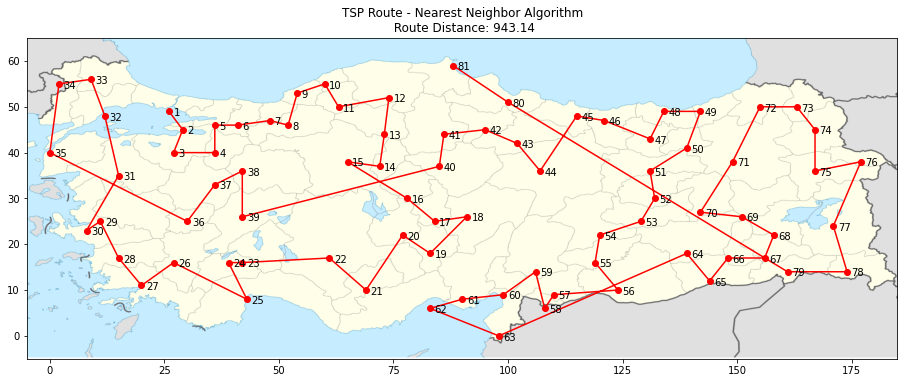

In [81]:
plot_tsp(df, TSP(df)[0])

#### Travelling Salesman Problem, route found by Self-Organizing Map algorithm. Gaussian Kernel is used for neighborhood function. 
#### Total route distances are given for the number of neurons [81,162,273], Turkey district map is used for aesthetics concerns, scales are not exactly accurate
#### beta : 0.95, learning rate : 0.90, sigma : 81, max iterations : 10,0000 , breaking diff between weights : 0.0001

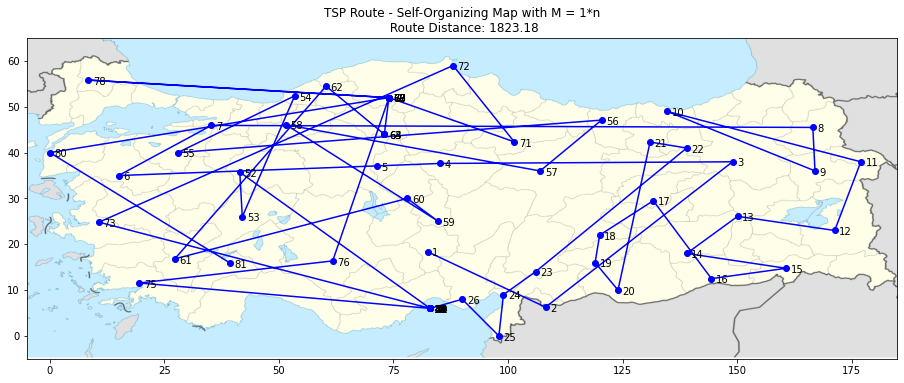

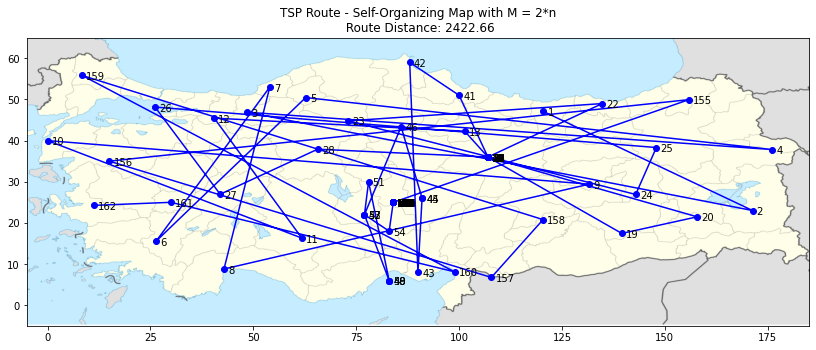

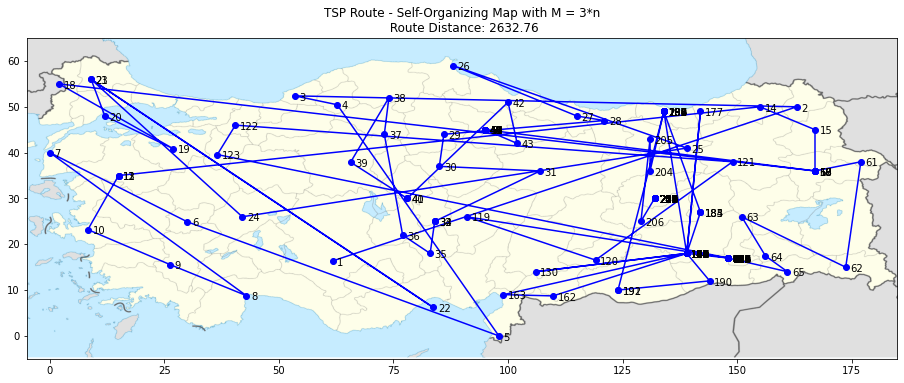

In [82]:
experiment(3, df, 0.95, 0.90, 81, 'Gaussian_Kernel') # Experiment for M = n, M = 2n and M = 3n, where M and n are respectively the number of neurons and cities.


#### Travelling Salesman Problem, route found by Self-Organizing Map algorithm. Elastic Band is used for neighborhood function. 
#### Total route distances are given for the number of neurons [81,162,273], Turkey district map is used for aesthetics concerns, scales are not exactly accurate
#### beta : 0.95, learning rate : 0.90, sigma : 81, max iterations : 10,0000 , breaking diff between weights : 0.0001

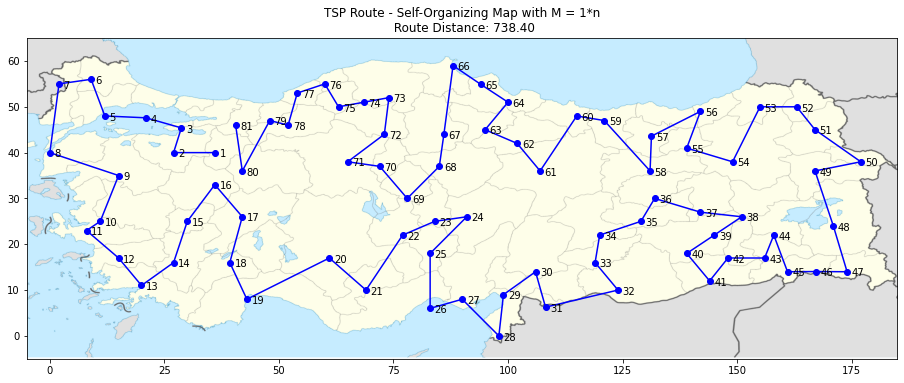

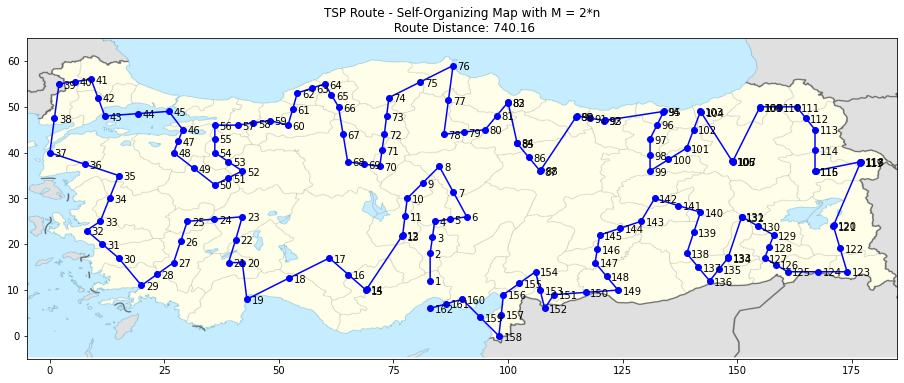

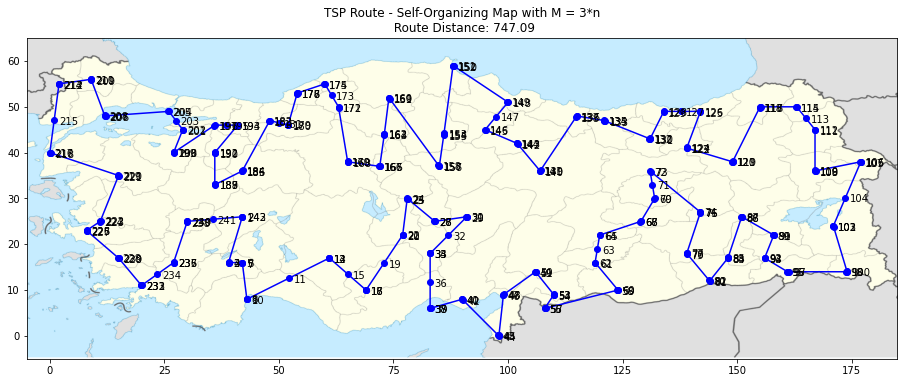

In [83]:
experiment(3, df, 0.95, 0.90, 81, 'Elastic_Band') # Experiment for M = n, M = 2n and M = 3n, where M and n are respectively the number of neurons and cities.
